<a href="https://colab.research.google.com/github/ASBRUC/DSPS_ABruce/blob/main/Labs/RegressionTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![github-badge](https://img.shields.io/badge/GitHub-sidchaini/TreeEnsembleTutorial-blue)](https://github.com/sidchaini/TreeEnsembleTutorial)

**Siddharth Chaini, 28th October, 2025**

(Thanks to Federica Bianco, Ashish Mahabal and Ajit Kembhavi)

# Classifying Variable Stars from the Zwicky Transient Facility

For this example, we will be using data from a paper of mine: [![arxiv-badge](https://img.shields.io/badge/arXiv-2403.12120-red)](https://arxiv.org/abs/2403.12120)

The paper is about classifying variable stars, but for this tutorial, I created a sample version of this consisting of 4 classes of stars (500 objects from each class).

We'll look at how to apply a random forest classifier as well as a boosted tree classifier.

## 0. Some Scientific Intro

The 4 classes stars are:
1. [Cepheid Variables](https://en.wikipedia.org/wiki/Cepheid_variable) (```CEP```)
2. [Delta Scuti Variables](https://en.wikipedia.org/wiki/Delta_Scuti_variable) (```DSCT```)
3. [Mira Variables](https://en.wikipedia.org/wiki/Mira_variable) (```Mira```)
4. [RR Lyrae Variables](https://en.wikipedia.org/wiki/RR_Lyrae_variable) (```RR```)

If you are interested in them, you can read more about them on their wikipedia pages (linked above).

These are all variable stars: meaning, that their brightness changes over time.

<img src="https://raw.githubusercontent.com/sidchaini/TreeEnsembleTutorial/refs/heads/main/animation.gif" width="400">

Each of them have some features to separate them. A plot of brightness over time is called a "light curve". From these light curves, we can extract summary features.


<img src="https://raw.githubusercontent.com/sidchaini/TreeEnsembleTutorial/refs/heads/main/lightcurve.png" width="400">

We'll be looking at:
1) **Period**: The time it takes for the star's brightness to complete one full cycle.
2) **Amplitude**: The range of brightness variation (max brightness - min brightness).
3) **Mean brightness**: The average brightness of the star.
4) **Std dev in brightness**: The standard deviation of the brightness measurements.


## 1. Data Preparation

### 1.1. Loading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/sidchaini/TreeEnsembleTutorial/refs/heads/main/variable_stars_ztf.csv", index_col=0)
df.head()

,Period_band_r,Amplitude_r,Mean_r,Std_r,class
oid,,,,,
513675,6.331223,0.330910,13.259128,0.229492,CEP
371805,2.818991,0.390815,15.791239,0.209911,CEP
46919,5.239933,0.222290,12.635843,0.123101,CEP
181873,2.251985,0.129499,14.097532,0.099477,CEP
437874,0.577279,0.176992,15.804207,0.111430,CEP


In [3]:
df["class"].value_counts()

,count
class,
CEP,500
DSCT,500
Mira,500
RR,500


In [4]:
feature_names = ["Period_band_r", "Amplitude_r", "Mean_r", "Std_r"]
X = df[feature_names].to_numpy()
y = df["class"].to_numpy()

### 1.2. Split into train-test

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print("Shape of training features:", X_train.shape)
print("Shape of testing features:", X_test.shape)
print("Shape of training labels:", y_train.shape)
print("Shape of testing labels:", y_test.shape)

Shape of training features: (1400, 4)
Shape of testing features: (600, 4)
Shape of training labels: (1400,)
Shape of testing labels: (600,)


In [6]:
np.unique(y_train, return_counts=True)

(array(['CEP', 'DSCT', 'Mira', 'RR'], dtype=object),
 array([350, 350, 350, 350]))

## 2. Random Forest

A Random Forest is an ensemble learning method that operates by constructing a many decision trees at training time, which are based on bagging. For a classification task, the final prediction is the class selected by most trees.

Two important things to consider,

- `max_depth`: This limits the maximum depth of each decision tree. A smaller depth can prevent overfitting by making the model less complex.
- `random_state` (seed): This ensures that the randomness involved in building the forest (like bootstrapping samples and selecting features) is the same every time, making our model's results reproducible.


---
NOTE: The syntax for regression is very similar. You would just import and use `RandomForestRegressor` instead of `RandomForestClassifier`.


### 2.1. Instantiate and Train

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    n_jobs=-1, random_state=44)
rf.fit(X_train, y_train)

print(f"Train Score: {rf.score(X_train, y_train):.2%}")
print(f"Test Score: {rf.score(X_test, y_test):.2%}")

Train Score: 96.14%
Test Score: 94.67%


In [13]:
rf.predict_proba(X_test)

array([[0.18901463, 0.0568055 , 0.00254703, 0.75163284],
       [0.18901463, 0.0568055 , 0.00254703, 0.75163284],
       [0.00274144, 0.99725856, 0.        , 0.        ],
       ...,
       [0.7753415 , 0.01414256, 0.00760554, 0.2029104 ],
       [0.78635834, 0.02384464, 0.00648358, 0.18331344],
       [0.18901463, 0.0568055 , 0.00254703, 0.75163284]])

### 2.2. Evaluate performance

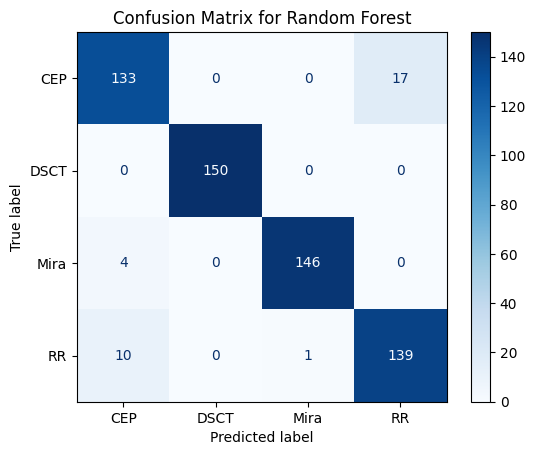

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize


fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
ax.set_title("Confusion Matrix for Random Forest")
plt.show()

In [11]:
def plot_roc_curve(y_test, rf):
  y_test_binarized = label_binarize(y_test, classes=rf.classes_)
  n_classes = y_test_binarized.shape[1]
  y_prob_rf = rf.predict_proba(X_test)

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob_rf[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  plt.figure()
  for i in range(n_classes):
      plt.plot(fpr[i], tpr[i], lw=2,
              label='{0} (area = {1:0.2f})'
              ''.format(rf.classes_[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC for Random Forest')
  plt.legend(loc="lower right")
  plt.show()

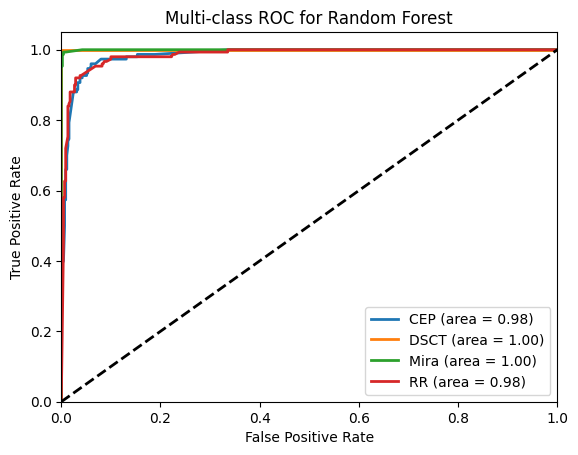

In [12]:
plot_roc_curve(y_test, rf)

## 3. GradientBoostingClassifier
A Gradient Boosting builds trees sequentially, and every new tree corrects the errors of the previous ones.

NOTE: For regression, the syntax is again very analogous: you would use `GradientBoostingRegressor`.

Also, another very popular implementation of gradient boosting is XGBoost. and is very similar: `from xgboost import XGBClassifier`.

But we'll use `sklearn` for this tutorial.


### 3.1. Instantiate and Train

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

gbt = GradientBoostingClassifier(
    n_estimators=100,
    max_depth=1,
    random_state=44)

gbt.fit(X_train, y_train)

print(f"Train Score: {gbt.score(X_train, y_train):.2%}")
print(f"Test Score: {gbt.score(X_test, y_test):.2%}")

Train Score: 96.50%
Test Score: 94.50%


### 3.2 Evaluate performance

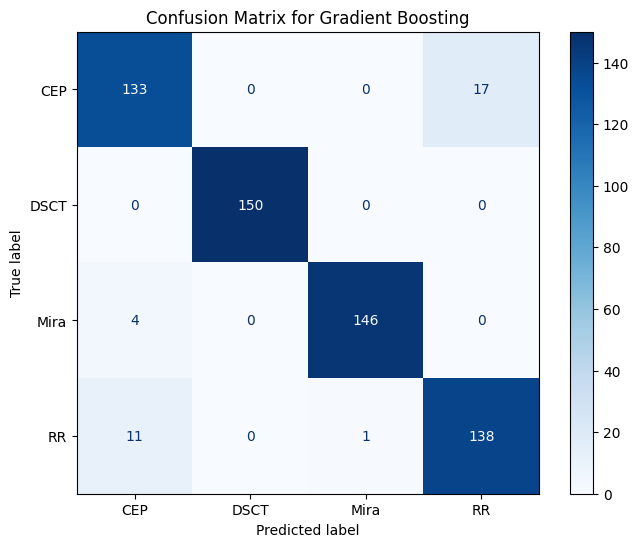

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(gbt, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
ax.set_title("Confusion Matrix for Gradient Boosting")
plt.show()

In [ ]:
plot_roc_curve(y_test, gbt)

## 4. Feature importance

In [ ]:
fistd = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
importances_rf = rf.feature_importances_

print("Random Forest feature importance:")
for f, fi, s in zip(feature_names, importances_rf, fistd):
  print(f, fi.round(3), "+/-", s.round(3))

indices_rf = np.argsort(importances_rf)

plt.figure()
plt.title("Feature importances (Random Forest)")
plt.barh(range(len(indices_rf)), importances_rf[indices_rf],
         xerr=fistd[indices_rf], align="center")
plt.yticks(range(len(indices_rf)), [feature_names[i] for i in indices_rf])
plt.xlabel("Importance")
plt.show()

In [ ]:
importances_gbt = gbt.feature_importances_
indices_gbt = np.argsort(importances_gbt)

print("\nGradient Boosting feature importance:")
for f, fi in zip(feature_names, importances_gbt):
  print(f, fi.round(3))


plt.figure()
plt.title("Feature importances (Gradient Boosting)")
plt.barh(range(len(indices_gbt)), importances_gbt[indices_gbt], align="center")
plt.yticks(range(len(indices_gbt)), [feature_names[i] for i in indices_gbt])
plt.xlabel("Importance")
plt.show()